In [1]:
import pandas as pd

from eoles.utils import get_config
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

# load heating demand
output = get_inputs(variables=['buildings'])
buildings = output['buildings']
heating_need = buildings.hourly_heating_need()

new_index_datetime = [datetime.datetime(col[0], col[2], col[3], col[1]) for col in heating_need.index.values]
new_index_hour = [int((e - datetime.datetime(2018, 1, 1, 0)).total_seconds() / 3600) for e in new_index_datetime]  # transform into number of hours
heating_need.index = new_index_hour
heating_need = heating_need.sort_index(ascending=True)

# aggregation
aggregation_archetype = ['Housing type', 'Heating system']  # argument for the function
heating_need_groupby = heating_need.groupby(aggregation_archetype, axis=1).aggregate(np.sum)
heating_need_groupby.columns = [" ".join(col) for col in heating_need_groupby.columns.values]

# total
heating_need_tot = heating_need.sum(axis=1)
heating_need_tot = heating_need_tot * 1e-6  # GWh

heating_need_tot = heating_need_tot * 0.7  # we reduce artificially the heating need by using expression
# from utilization rate

# dict_demand
heating_demand = {
    "all_stock": heating_need_tot
}

2022-11-17 17:54:42,717 - 55085 - log_ - INFO - Creating AgentBuildings object


In [52]:
heating_need_tot

0       64.836865
1       72.246792
2       75.951756
3       77.804238
4       85.214165
          ...    
8755    75.237484
8756    67.897242
8757    62.392060
8758    60.557000
8759    77.072545
Length: 8760, dtype: float64

<AxesSubplot:>

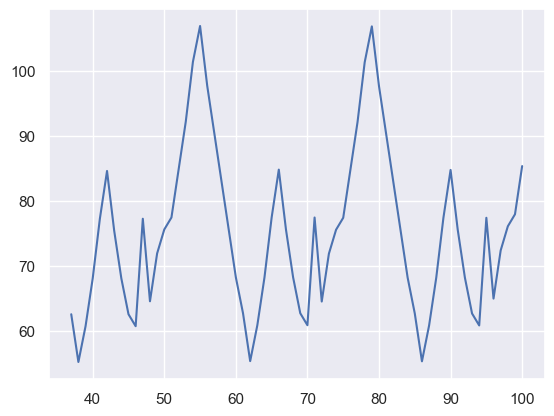

In [55]:
sns.lineplot(heating_need_tot.loc[37:100])

In [51]:
heating_need_tot.sum() / 0.8

396940.54437148885

In [43]:
list_scc = [0, 100, 200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame()
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuc", "biogas1", "biogas2", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=heating_demand, nb_linearize=3,
                       social_cost_of_carbon=scc, year=2050)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().transpose()], axis=0, ignore_index=True)

Social cost of carbon: 0


2022-11-17 18:16:58,572 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-17 18:17:29,114 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:795: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:839: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 100


2022-11-17 18:17:44,471 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-17 18:18:24,785 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:795: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:839: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 200


2022-11-17 18:18:40,378 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-17 18:19:25,678 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:795: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:839: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 300


2022-11-17 18:19:41,164 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-17 18:20:26,800 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:795: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:839: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 400


2022-11-17 18:20:42,712 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-17 18:21:13,910 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:795: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:839: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


Social cost of carbon: 500


2022-11-17 18:21:29,108 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-17 18:22:11,086 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:795: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_volume = (costs_elec_to_CH4 + costs_CH4_to_demand) / CH4_demand_tot  # € / MWh
/Users/celia/Documents/These/python_projects/eoles2/eoles/model_heat_coupling.py:839: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_CH4_value = (costs_elec_to_CH4_value + costs_CH4_to_demand_value) / CH4_demand_tot  # € / MWh


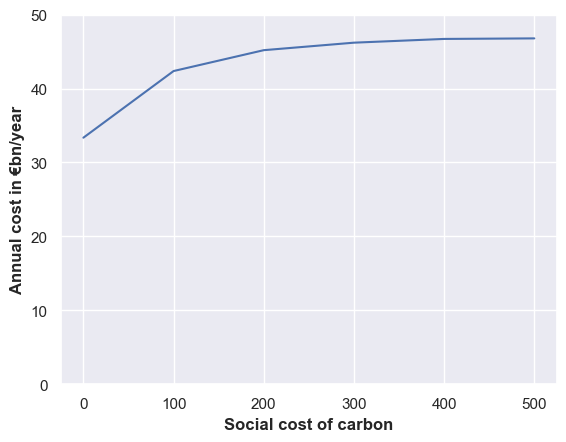

In [44]:
# set seaborn style
sns.set_theme()

plt.plot(list_scc, list_social_cost)
plt.ylim(0, 50)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

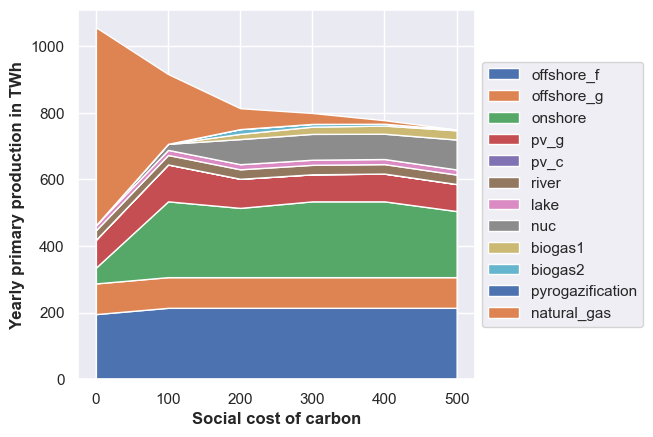

In [45]:
list_primary_production = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

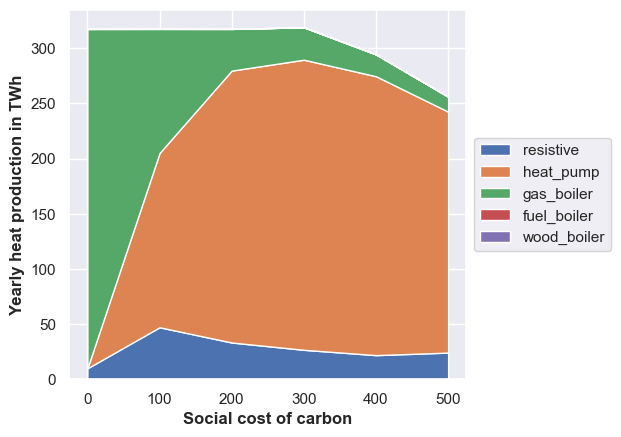

In [46]:
list_heat_generation = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [47]:
renovation_rate_df.index = list_scc
renovation_rate_df = renovation_rate_df.stack().reset_index().rename(columns={"level_0": "scc", "level_1": "archetype", 0: "renovation_rate"})
renovation_rate_df

,scc,archetype,renovation_rate
0,0,all_stock,0.000000
1,100,all_stock,0.000000
2,200,all_stock,0.000000
3,300,all_stock,0.000000
4,400,all_stock,0.073015
5,500,all_stock,0.196223


<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

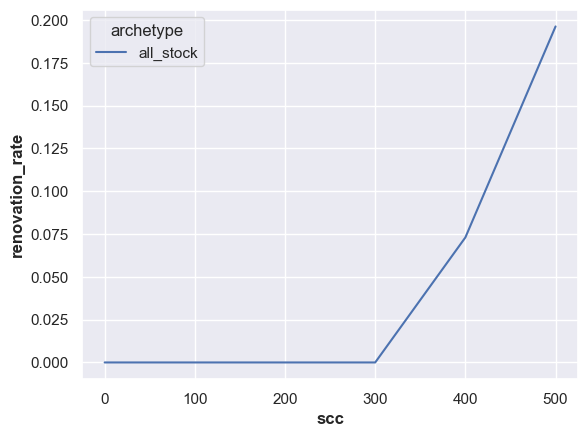

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")